In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm_notebook as tqdm
from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *

C:\Users\MEDIA_LAB\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\MEDIA_LAB\thesis_project


In [2]:
X = genX([1994,2014], drop_0 = True) # Load dataframe

dropping all zero rows


In [3]:
# Only look at weekdays
df = X.copy()
df.reset_index(inplace = True)

# extract weekdays
df['day_names'] = df.date.dt.day_name()

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']

df['daytype'] = df.day_names.where(~df.day_names.isin(weekdays), 'weekday')

df.drop(['day_names'], axis = 1, inplace = True)

df_weekdays = df[df['daytype'] == 'weekday'] # Create dataframe with only weekdays

df_weekdays.set_index(['ProfileID'], inplace=True)
df_weekdays.drop(['daytype'],axis = 1, inplace = True)

C:\Users\MEDIA_LAB\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
mean = df_weekdays.groupby(["ProfileID"]).mean()

# Calculate the energy between 9-5

In [5]:
i = np.arange(9,17)
sum_df = pd.DataFrame(index = mean.index, columns = ["9_to_5", 'total'])
sum_df = sum_df.fillna(0)
for x in i:
    temp = mean.iloc[:,x]
    sum_df['9_to_5'] = sum_df['9_to_5'] + temp

sum_df['total'] =  mean.sum(axis = 1)

In [6]:
sum_df["percentage"] = (sum_df["9_to_5"]/sum_df["total"]) * 100

In [7]:
def check_9_to_5(df):
    if df > 50:
        return 'B'
    else: 
        return 'R'

In [8]:
sum_df['Labels'] = sum_df['percentage'].apply(check_9_to_5)

In [9]:
# 173 households labeled as Businesses for the 9-to-5 check
sum_df[sum_df['percentage'] > 50]

,9_to_5,total,percentage,Labels
ProfileID,,,,
217,26.131673,46.794261,55.843756,B
232,38.626513,76.085126,50.767497,B
284,20.822542,39.904126,52.181426,B
294,3.974973,7.621575,52.154223,B
306,9.190674,18.363042,50.049846,B
...,...,...,...,...
12027862,1.426371,2.773840,51.422269,B
12027927,23.003779,42.168680,54.551812,B
12028403,6.007670,7.263800,82.706982,B


# Look at ToPs, label households

In [10]:
top_df = pd.DataFrame()

top_df['Time'] = mean.idxmax(axis=1)

In [11]:
def check_top(df):
    if int(df) > 9 and int(df) < 17:
        return 'B'
    else:
        return 'R'    

In [12]:
top_df['Labels'] = top_df['Time'].apply(check_top)

In [13]:
len(top_df[top_df['Labels'] == 'B'])

842

# Look at AMC, label households

In [14]:
Xbin = xBins(X, 'amd')

In [15]:
ids = Xbin['1000-4000']

In [16]:
amc_df = pd.DataFrame(index = mean.index.unique(), columns = ['Labels'])

In [17]:
amc_df.loc[ids] = 'B'

In [18]:
amc_df.loc[~amc_df.index.isin(ids)] = 'R'

In [19]:
amc_df['Labels'].unique()

array(['R', 'B'], dtype=object)

# Look at midday and late afternoon usage, label households

In [20]:
# mid = 20
# late = 25

# lst = [mid,late]

# diff = np.abs(mid - late)

# perc = (diff/max(lst))*100

In [21]:
# def mid_late_perc(df):
#     mid = df.mid
#     late = df.late

#     lst = [mid, late]

#     diff = np.abs(mid - late)

#     return (diff/max(lst))*100

In [22]:
# mid_i = np.arange(12,15)
# late_i = np.arange(15,18)
# mid_late_df = pd.DataFrame(index = mean.index, columns = ["mid", 'late'])
# mid_late_df = mid_late_df.fillna(0)
# for x in mid_i:
#     temp1 = mean.iloc[:,x]
#     mid_late_df['mid'] = mid_late_df['mid'] + temp1

# for y in late_i:
#     temp2 = mean.iloc[:,x]
#     mid_late_df['late'] = mid_late_df['late'] + temp2


In [23]:
# mid_late_df['perc'] = mid_late_df.apply(mid_late_perc, axis = 1)

In [24]:
# def mid_late_labeler(df):
#     if df > 1:
#         return 'R'
#     else:
#         return 'B'


In [25]:
# mid_late_df['Label'] = mid_late_df['perc'].apply(mid_late_labeler)

In [26]:
# len(mid_late_df[mid_late_df['Label'] == 'B'])

# Determine how many theoretical businesses are there

In [27]:
new_df = pd.DataFrame()

new_df['AMC'], new_df['ToP'], new_df['Sum'] = amc_df['Labels'], top_df['Labels'], sum_df['Labels']

In [28]:
data_classes = ['R','B']
d = dict(zip(data_classes, range(0,2)))

new_df['AMC'], new_df['ToP'],new_df['Sum'] = new_df['AMC'].map(d, na_action='ignore'),new_df['ToP'].map(d, na_action='ignore'),new_df['Sum'].map(d, na_action='ignore')

new_df['Total'] = new_df.sum(axis = 1)

new_df['Total'].unique()

array([0, 1, 2, 3], dtype=int64)

In [29]:
len(new_df[new_df['Total'] == 0])

13417

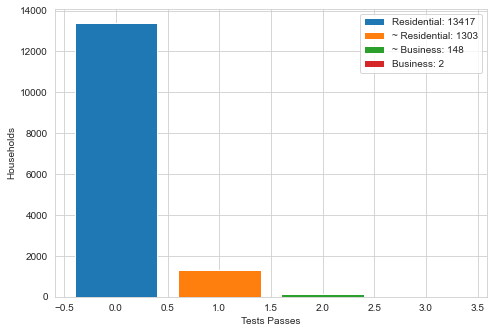

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# langs = [0,1,2,3]
# students = [len(new_df[new_df['Total'] == 0]),len(new_df[new_df['Total'] == 1]),len(new_df[new_df['Total'] == 2]),len(new_df[new_df['Total'] == 3])]
y1 = len(new_df[new_df['Total'] == 0])
y2 = len(new_df[new_df['Total'] == 1])
y3 = len(new_df[new_df['Total'] == 2])
y4 = len(new_df[new_df['Total'] == 3])
# ax.bar(langs,students)
ax.bar(0,y1,label = "Residential: " + str(len(new_df[new_df['Total'] == 0])))
ax.bar(1,y2,label = "~ Residential: " + str(len(new_df[new_df['Total'] == 1])))
ax.bar(2,y3,label = "~ Business: " + str(len(new_df[new_df['Total'] == 2])))
ax.bar(3,y4,label = "Business: " + str(len(new_df[new_df['Total'] == 3])))
ax.set_xlabel("Tests Passes")
ax.set_ylabel("Households")
ax.legend()

plt.show()

# Filter out the households that have two matches

In [50]:
business_ids = new_df[new_df['Total'] >= 2].index.values

In [51]:
business_ids

array([     192,      200,      202,      217,      284,      294,
            520,      677,      678,      700,      708,      716,
            920,      961,     1029,     1233,     1423,     1530,
           1559,     1583,     1584,     1915,     2274,     2399,
           2469,     2820,     2950,     3051,     3534,     3843,
           4060,     4061,     4494,     4513,     4579,     4652,
           4659,     4747,     4754,     4755,     5255,     5335,
           6473,     6778,     6830,     6877,     6917,     7103,
           7113,     7223,     7233,     7247,     7257,     7258,
           7323,     7537,     7538,     7589,     7646,     7686,
           7688,     7900,     8040,     8292,     8293,     8397,
           8400,     8441,     8579,    10266,    10456,    10482,
          10790,    11171,    11180,    11193,  1000353,  1000438,
        1000650,  1000825,  1000828,  1000948,  1001132,  1001139,
        1001226,  1001302,  1002187,  1002256,  1002348,  1002

In [53]:
import pickle as pickle
# create a binary pickle file 
f = open("business_ids.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(business_ids,f)

# close file
f.close()

data = pd.read_pickle('business_ids.pkl') # Read pickle file

In [54]:
data

array([     192,      200,      202,      217,      284,      294,
            520,      677,      678,      700,      708,      716,
            920,      961,     1029,     1233,     1423,     1530,
           1559,     1583,     1584,     1915,     2274,     2399,
           2469,     2820,     2950,     3051,     3534,     3843,
           4060,     4061,     4494,     4513,     4579,     4652,
           4659,     4747,     4754,     4755,     5255,     5335,
           6473,     6778,     6830,     6877,     6917,     7103,
           7113,     7223,     7233,     7247,     7257,     7258,
           7323,     7537,     7538,     7589,     7646,     7686,
           7688,     7900,     8040,     8292,     8293,     8397,
           8400,     8441,     8579,    10266,    10456,    10482,
          10790,    11171,    11180,    11193,  1000353,  1000438,
        1000650,  1000825,  1000828,  1000948,  1001132,  1001139,
        1001226,  1001302,  1002187,  1002256,  1002348,  1002